In [1]:
%matplotlib inline

# Welcome to Exercise 08
`exercise 05`를 해당 프레임워크를 사용해서 풀어봅시다

## nn.Transformer 와 TorchText 로 시퀀스-투-시퀀스(Sequence-to-Sequence) 모델링하기

08번의 예제에서는 TransformerEncoder + FCN만을 사용하여 SRC, TRG가 둘 다 똑같은 language modeling task를 풀었습니다<br> 
이번 Exercise 에서는 machine translation 문제를 풀려고 합니다. 이때 SRC와 TRG는 vocab 크기도 다르고 pair 쌍의 길이도 다를 것입니다<br>
즉 output이 그저 shifted right인 SRC가 아니기 때문에 TransformerDecoder를 사용하여 문제를 풀어야합니다.<br>
또한 teacher-forcing 방법으로 문제를 풀려고 합니다. (transformer에서 (t-1)기의 output을 input으로 주는 방법에 대해서는 아직 잘 모르겠습니다)

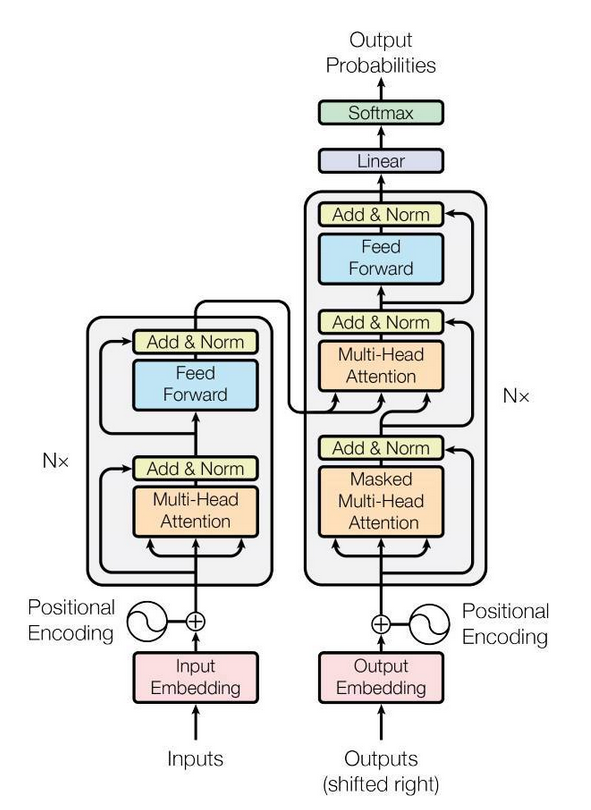

``PositionalEncoding`` 모듈은 시퀀스 안에서 토큰의 상대적인 또는 절대적인 포지션에 대한 어떤 정보를 주입합니다.
포지셔널 인코딩은 임베딩과 합칠 수 있도록 똑같은 차원을 가집니다.
여기에서, 우리는 다른 주파수(frequency) 의 ``sine`` 과 ``cosine`` 함수를 사용합니다.




데이터 로드하고 배치 만들기
-------------------




### DataLoading

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pickle

In [3]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('../data/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    return pairs
    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
pairs = readLangs('eng', 'fra')

Reading lines...


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
pairs = filterPairs(pairs)

In [9]:
train, test = train_test_split(pairs, train_size=0.7)

In [11]:
# train

In [12]:
import pandas as pd

In [13]:
pd.DataFrame(train).to_csv('../data/train_eng_fra.csv', index=None)
pd.DataFrame(test).to_csv('../data/test_eng_fra.csv', index=None)

학습 과정에서는 ``torchtext`` 의 Wikitext-2 데이터셋을 이용합니다.
단어 오브젝트는 훈련 데이터셋(train dataset) 에 의하여 만들어지고, 토큰을 텐서(tensor)로 수치화하는데 사용됩니다.
시퀀스 데이터로부터 시작하여, ``batchify()`` 함수는 데이터셋을 컬럼들로 배열하고, ``batch_size`` 사이즈의 배치들로 나눈 후에 남은 모든 토큰을 버립니다.
예를 들어, 알파벳을 시퀀스(총 길이 26) 로 생각하고 배치 사이즈를 4라고 한다면, 우리는 알파벳을 길이가 6인 4개의 시퀀스로 나눌 수 있습니다.

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

이 컬럼들은 모델에 의해서 독립적으로 취급되며, 이것은 더 효율적인 배치 프로세싱(batch processing) 이 가능하지만, ``G`` 와 ``F`` 의 의존성이 학습될 수 없다는 것을 의미합니다.




In [14]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.data import Field, BucketIterator, TabularDataset
from torch.utils.data import Dataset, DataLoader

In [15]:
SRC = Field(tokenize = lambda e: e.split(),
            tokenizer_language = 'eng',
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False)

TRG = Field(tokenize = lambda e: e.split(),
            tokenizer_language = 'fra',
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [16]:
train_ds = torchtext.data.TabularDataset('../data/train_eng_fra.csv', 
                                      format='csv', skip_header=True, 
                                      fields=[('src', SRC), ('trg', TRG)])

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [17]:
test_ds = torchtext.data.TabularDataset('../data/test_eng_fra.csv', 
                                      format='csv', skip_header=True, 
                                      fields=[('src', SRC), ('trg', TRG)])

In [18]:
test_ds.examples[0].src

['i', 'm', 'calling', 'from', 'my', 'cell', 'phone', '.']

In [21]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

In [22]:
SRC.build_vocab(train_ds)
TRG.build_vocab(train_ds)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [24]:
bs = 20

In [25]:
from torchtext.data import Iterator, BucketIterator

In [26]:
train_dl = Iterator(train_ds, batch_size = bs, sort_key=lambda e: len(e.src), shuffle=True)
test_dl = Iterator(test_ds, batch_size = bs, sort_key=lambda e: len(e.src), shuffle=True)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [28]:
for batch in train_dl:
    print(batch.src)
    print(torch.transpose(batch.src, 0,1))
    break

tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2],
        [   5,    5,   14,    5,   18,   14,    5,    9,   22,    9,    5,   22,
            5,    5,    5,    9,   18,   14,    5,   14],
        [   7,   21,    6,    7,   11,    6,   21,   11,    6,   15,    7,    6,
            7,    7,    7,   11,   15,   17,    7,    6],
        [  42,  270,   24,   39,   47,   16,  127,  148,  363, 1598,   24,   19,
          261,   12,  726,   61, 1178,   39,  334,  534],
        [  14,   78,   13,   13,  939,  135,  299,   26,    4,   44,   13,  274,
           32,   73,   16,   47,  164,   14,    4,    4],
        [2236,    8, 1854,   88,  107,    4,  119,  115,    3,   22,   65,  101,
           63,    4,  621, 1513,  486,  147,    3,    3],
        [  64,   17,   13,  373,    4,    3,    4, 1074,    1,   17,   12,    4,
          572,    3,    4,    4,    4,   36,    1,    1],
        [   4,  188,  375, 

입력(input) 과 타겟(target) 시퀀스를 생성하기 위한 함수들

``get_batch()`` 함수는 트랜스포머 모델을 위한 입력과 타겟 시퀀스를 생성합니다.
이 함수는 소스 데이터를 ``bptt`` 길이를 가진 덩어리로 세분화 합니다.
언어 모델링 과제를 위해서, 모델은 다음 단어인 ``Target`` 이 필요 합니다.
예를 들어, ``bptt`` 의 값이 2 라면, 우리는 i = 0 일 때(첫번째 토큰일 때,) 다음의 2 개의 변수(Variable) 를 얻을 수 있습니다:

![](../_static/img/transformer_input_target.png)


변수 덩어리는 트랜스포머 모델의 ``S`` 차원과 일치하는 0 차원에 해당합니다.
배치 차원 ``N`` 은 1 차원에 해당합니다.




모델 정의하기
----------------




In [31]:
class PositionalEncoding(nn.Module):
    # positional encoding layer 따로 정의 
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model) # positonal encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수는 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수는 cos 함수 적용
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

<b> torch.nn.TransformerEncoderLayer</b>(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu')
- d_model – the number of expected features in the input (required).
- nhead – the number of heads in the multiheadattention models (required).
- dim_feedforward – the dimension of the feedforward network model (default=2048).
- dropout – the dropout value (default=0.1).
- activation – the activation function of intermediate layer, relu or gelu (default=relu).

<b>torch.nn.TransformerEncoder</b>(encoder_layer, num_layers, norm=None)<br>
: stack of N encoder layers
- encoder_layer – an instance of the TransformerEncoderLayer() class (required).
- num_layers – the number of sub-encoder-layers in the encoder (required).
- norm – the layer normalization component (optional).<br>
forward(*src: torch.Tensor, mask, src_key_padding_mask*)
- src – the sequence to the encoder (required).
- mask – the mask for the src sequence (optional).
- src_key_padding_mask – the mask for the src keys per batch (optional).

**torch.nn.TransformerDecoderLayer**(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu')
- d_model – the number of expected features in the input (required).
- nhead – the number of heads in the multiheadattention models (required).
- dim_feedforward – the dimension of the feedforward network model (default=2048).
- dropout – the dropout value (default=0.1).
- activation – the activation function of intermediate layer, relu or gelu (default=relu).

**torch.nn.TransformerDecoder**(decoder_layer, num_layers, norm=None)<br>
: TransformerDecoder is a stack of N decoder layers
- decoder_layer – an instance of the TransformerDecoderLayer() class (required).
- num_layers – the number of sub-decoder-layers in the decoder (required).
- norm – the layer normalization component (optional).

        >>> decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        >>> transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        >>> memory = torch.rand(10, 32, 512)
        >>> tgt = torch.rand(20, 32, 512)
        >>> out = transformer_decoder(tgt, memory)

 forward(tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: Optional[torch.Tensor] = None, memory_mask: Optional[torch.Tensor] = None, tgt_key_padding_mask: Optional[torch.Tensor] = None, memory_key_padding_mask: Optional[torch.Tensor] = None) → torch.Tensor
[source]

    Pass the inputs (and mask) through the decoder layer in turn.

    Parameters

            tgt – the sequence to the decoder (required).

            memory – the sequence from the last layer of the encoder (required).

            tgt_mask – the mask for the tgt sequence (optional).

            memory_mask – the mask for the memory sequence (optional).

            tgt_key_padding_mask – the mask for the tgt keys per batch (optional).

            memory_key_padding_mask – the mask for the memory keys per batch (optional).




In [135]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken_src, ntoken_trg,
                 d_model, nhead, dim_feedforward, nlayers, dropout=0.5):
        # ntoken : the number of tokens in sequence 
        # d_model : the number of expected features in the input
        # nhead : the number of heads in multi-head attention model 
        # dim_feedforward : the dimension of the feedforward network model 
        # nlayers : the number of sub-encoder-layers in the encoder
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        self.embedding_encoder = nn.Embedding(ntoken_src, d_model)
        self.embedding_decoder = nn.Embedding(ntoken_trg, d_model)
        
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        decoder_layers = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)

        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        
        self.linear = nn.Linear(d_model, ntoken_trg)
        self.softmax = nn.Softmax(dim=1)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        # encoder의 nn.Embedding의 레이어 초기화
        self.embedding_encoder.weight.data.uniform_(-initrange, initrange)
        self.embedding_decoder.weight.data.uniform_(-initrange, initrange)
        self.linear.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()

    def forward(self, src, trg):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.embedding_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        
        trg = self.embedding_decoder(trg) * math.sqrt(self.d_model)
        trg = self.pos_encoder(trg)
        output = self.transformer_encoder(src, self.src_mask) 
        # [10, 20, 200]
        output = self.transformer_decoder(trg, output)
        output = self.linear(output)
        # torch.Size([10, 20, 4347])
        output = self.softmax(output)
        return output

인스턴스(instance) 초기화하기
--------------------




모델은 아래와 같은 하이퍼파라미터(hyperparameter) 로 세팅 됩니다.
단어 사이즈는 단어 오브젝트의 길이와 일치 합니다.




In [136]:
len(SRC.vocab.stoi), len(TRG.vocab.stoi)

(2805, 4347)

In [137]:
ntokens_src = len(SRC.vocab.stoi) # 단어 사전의 크기
ntokens_trg = len(TRG.vocab.stoi) # 단어 사전의 크기
emsize = 200  # 임베딩 차원
nhid = 200    # nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2   # nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수
nhead = 2     # 멀티헤드 어텐션(multi-head attention) 모델의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 값
model = TransformerModel(ntokens_src, ntokens_trg,
                         emsize, nhead, nhid, nlayers, dropout).to(device)

모델 실행하기
-------------

손실(loss) 을 추적하는 데에는
`CrossEntropyLoss`가 적용되며, 옵티마이저(optimizer) 로서
`SGD`는 확률적 경사 하강법(stochastic gradient descent method) 을 구현합니다.
초기 학습률(learning rate) 은 5.0 으로 설정됩니다.
`StepLR`
은 에포크(epoch) 에 따라서 학습률을 조절하는데 사용됩니다.
학습하는 동안에, 우리는 기울기 폭발(gradient exploding) 을 방지하기 위하여 모든 기울기를 함께 스케일(scale) 하는 함수인
`nn.utils.clip_grad_norm`
을 이용합니다.

### nn.CrossEntropyLoss
nn.CrossEntrolyLoss expects a model output in the shape [batch_size, nb_classes, *additional_dims] and a target in the shape [batch_size, *additional_dims] containing the class indices in the range [0, nb_classes-1].

Based on your output shape it seems you are dealing with 17451 classes and a temporal dimension of 5. The target should thus have a shape of [1, 5] (note the missing channel dimension).

    >>> loss = nn.CrossEntropyLoss()
    >>> input = torch.randn(3, 5, requires_grad=True)
    >>> target = torch.empty(3, dtype=torch.long).random_(5)
    >>> output = loss(input, target)
    >>> output.backward()

In [138]:
criterion = nn.CrossEntropyLoss()
lr = 0.005 # 학습률
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [139]:
import time

In [140]:
type(train_ds)

torchtext.data.dataset.TabularDataset

In [141]:
log_interval = 100

In [142]:
def train_model(iterator):
    model.train() # 학습 모드를 시작합니다.
    total_loss = 0.
    start_time = time.time()
    for _, batch in enumerate(train_dl):
        # BucketIterator는 꼭 batch size가 지정된 bs가 아닐 수도 있음 drop_last기능이 없음
        if batch.src.shape[1] == bs:
            src = batch.src
            trg = batch.trg
            output = model(src, trg)
            output = torch.transpose(output, 1, 2)
            loss = criterion(output, trg)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(), 20
            total_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
        if _ % log_interval == 0 and _ > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.5f} | ms/batch {:5.2f} | '
                  'loss {:5.9f} | ppl {:8.2f}'.format(
                    epoch, _, len(train_dl), scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

에포크 내에서 반복됩니다. 만약 검증 오차(validation loss) 가 우리가 지금까지 관찰한 것 중 최적이라면 모델을 저장합니다.
매 에포크 이후에 학습률을 조절합니다.



In [143]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [158]:
def evaluate(model, test_iter):
    model.eval()
    correct = 0
    n_all = 0
    for batch in test_iter:
        if batch.src.shape[1] == bs:
            src = batch.src
            trg = batch.trg
            output = model(src, trg)
            output = torch.argmax(output, dim=2)
            correct += (output == trg).sum()
            n_all += output.shape[0] * output.shape[1]
    return correct / n_all

In [162]:
best_val_loss = float("inf")
epochs = 20 
best_model = None


for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_model(train_dl)
    val_loss = evaluate(model, test_dl)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid accuracy {:5.9f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |   100/  371 batches | lr 0.00349 | ms/batch 31.51 | loss 8.381303902 | ppl  4364.70
| epoch   1 |   200/  371 batches | lr 0.00349 | ms/batch 30.01 | loss 8.295816956 | ppl  4007.08
| epoch   1 |   300/  371 batches | lr 0.00349 | ms/batch 29.87 | loss 8.292058897 | ppl  3992.04
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 12.65s | valid accuracy 0.206275418
-----------------------------------------------------------------------------------------
| epoch   2 |   100/  371 batches | lr 0.00332 | ms/batch 30.38 | loss 8.372908354 | ppl  4328.21
| epoch   2 |   200/  371 batches | lr 0.00332 | ms/batch 29.93 | loss 8.289463520 | ppl  3981.70
| epoch   2 |   300/  371 batches | lr 0.00332 | ms/batch 30.38 | loss 8.286691942 | ppl  3970.68
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 12.61s | valid accuracy 0.217052028
----------------

| epoch  16 |   300/  371 batches | lr 0.00162 | ms/batch 30.02 | loss 8.239610548 | ppl  3788.06
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 12.63s | valid accuracy 0.290179610
-----------------------------------------------------------------------------------------
| epoch  17 |   100/  371 batches | lr 0.00154 | ms/batch 31.04 | loss 8.320481558 | ppl  4107.14
| epoch  17 |   200/  371 batches | lr 0.00154 | ms/batch 30.23 | loss 8.235953989 | ppl  3774.24
| epoch  17 |   300/  371 batches | lr 0.00154 | ms/batch 30.97 | loss 8.236163559 | ppl  3775.03
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 13.20s | valid accuracy 0.293290913
-----------------------------------------------------------------------------------------
| epoch  18 |   100/  371 batches | lr 0.00146 | ms/batch 31.51 | loss 8.318875799 | ppl  4100.55
| epoch  18 |   200/  37